# Evaluation and Optimization Lab
<font color="red">Notice that this Lab is part B of <a href="https://github.com/ipetel/AWS_Certified_ML-acloud.guru/tree/master/CHAPTER%207%20-%20Algorithms/Algorithms%20Lab">Algorithms Lab</a></font>

<u>Use Case</u>
<p>Mr. K has given us the go to use the Linear Learner model for identifying the legitimacy of a reported UFO sighting. He plans to send out a team of scientist to any reported sighting predicted probable or unexplained. Before deploying the model, he wants us to make sure we have the most optimized model, improve any performance in training, and possibly improve accuracy.
</p>

<u>Goal</u>
<p>Tune our model to find the most optimized model for our problem.</p>

<u>Notebook - Table Of Contents</u>

1. [Datasets](#d)
1. [Hyperparameter Tuning Job](#h)
1. [Inference using the Best Training Job](#b)
1. [Results](#res)

<u>Note</u>
1. in most of code cell that I'm using external libraries I'm importing it every time, although I can import all of them once on the start of the notebook, I wanted to show what libraries I'm using on every step.
2. there are numerous times that I'm assigning the same variables with the same values on different cells, again just want to to show what variables are used on every step.

## Datasets<a id='d'></a>
From the previous lab (Algorithms Lab) we have train, validation, and train datasets in S3 that are already cleaned and tansformed. 

In [16]:
import boto3

bucket_name = '<PUT_HERE_THE_BUCKET_NAME>'
data_folder_path = 'AlgorithmsLab - 2019'
file_names_list=['ufo-algorithms-lab-train.csv',
                 'ufo-algorithms-lab-validation.csv',
                 'ufo-algorithms-lab-test.csv',
                 'ufo-algorithms-lab-test-no-label.csv']

s3_path_train = 's3://{}/'.format(bucket_name)+data_folder_path+'/'+file_names_list[0]
s3_path_validation = 's3://{}/'.format(bucket_name)+data_folder_path+'/'+file_names_list[1]
s3_path_test = 's3://{}/'.format(bucket_name)+data_folder_path+'/'+file_names_list[2]
s3_path_test_without_label='s3://{}/'.format(bucket_name)+data_folder_path+'/'+file_names_list[3]


import sagemaker

# create inputs channels
s3_input_train = sagemaker.s3_input(s3_data=s3_path_train, content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data=s3_path_validation, content_type='text/csv')
s3_input_test = sagemaker.s3_input(s3_data=s3_path_test, content_type='text/csv')

data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation,
    'test':s3_input_test
}

## Hyperparameter Tuning Job<a id='h'></a>
Create a training job

In [39]:
output_folder_path='EvaluationAndOptimizationLab - 2019/'
output_location = 's3://{}/{}'.format(bucket_name,output_folder_path+'output/')

# get IAM role
from sagemaker import get_execution_role
role = get_execution_role()

# Configure training job, establish SagMaker session
sess = sagemaker.Session()

# get ECR container
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner','1')

# create Estimator
LinearLearner_conf = sagemaker.estimator.Estimator(container,
                                                   role,
                                                   train_instance_count=1,
                                                   train_instance_type='ml.m5.4xlarge',
                                                   output_path=output_location,
                                                   sagemaker_session=sess)

#for 'train_instance_type' go to https://aws.amazon.com/sagemaker/pricing/instance-types/

In [3]:
from datetime import datetime

training_job_name='ufo-evaluationAndOptimization-linearLearner-classification-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

# for 'hyperparameters' go to: https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
LinearLearner_conf.set_hyperparameters(feature_dim=14,
                                       predictor_type='multiclass_classifier',
                                       num_classes=3,
                                       balance_multiclass_weights='true',
                                       loss='softmax_loss',
                                       normalize_data='false',
                                       optimizer='adam')

define the hyperparameter ranges and the objective metric:

In [4]:
# for Tuning Linear Learner Hyperparameters there are only 6 possible Hyperparameters to tune, I added them all
# for more info go to: https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, CategoricalParameter, HyperparameterTuner

hyperparameter_ranges = {'wd': ContinuousParameter(1e-7, 1),
                         'l1': ContinuousParameter(1e-7, 1),
                         'learning_rate': ContinuousParameter(1e-5, 1),
                         'mini_batch_size': IntegerParameter(100, 5000),
                         'use_bias': CategoricalParameter([True, False]),
                         'positive_example_weight_mult': ContinuousParameter(1e-5, 1e5)}

Now, we'll create a HyperparameterTuner object, to which we pass the estimator, hyperparameter ranges, Objective metric, and Tuning resource configurations.

In [5]:
objective_metric_name = 'validation:objective_loss'

tuner = HyperparameterTuner(estimator=LinearLearner_conf,
                            objective_metric_name=objective_metric_name,
                            hyperparameter_ranges=hyperparameter_ranges,
                            strategy='Bayesian',
                            objective_type='Minimize',
                            max_jobs=50,
                            max_parallel_jobs=5,
                            base_tuning_job_name='HyperparameterTuner_LinearLearner-')

Launch Hyperparameter Tuning:

In [ ]:
hyperparameter_tuning_job_name='ll-multiclass-HyperparamTuning-1'
tuner.fit(inputs=data_channels, job_name=hyperparameter_tuning_job_name ,include_cls_metadata=False)

Let's just run a quick check of the hyperparameter tuning jobs status to make sure it Completed.

In [7]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hyperparameter_tuning_job_name)['HyperParameterTuningJobStatus']

'Completed'

Hyper Parameter Tuning Job Completed, now let's get the best model and check the accuracy for the test dataset.
## Inference using the Best Training Job<a id='b'></a>

In [8]:
tuning_job_result=boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=hyperparameter_tuning_job_name)
best_training_job_name = tuning_job_result['BestTrainingJob']['TrainingJobName']

Create model from best training job

In [9]:
#for more info about "Model" go to :https://sagemaker.readthedocs.io/en/stable/model.html
best_training_job_model=sagemaker.model.Model(model_data='s3://{}/'.format(bucket_name)+'EvaluationAndOptimizationLab - 2019/output/'+best_training_job_name+'/output/model.tar.gz',
                                              role=role,
                                              image=container,
                                              name='best-training-job-LinearLearner-1',
                                              sagemaker_session=sess)

Batch Transform (test the model)

In [ ]:
#for more info about "transformer" go to https://sagemaker.readthedocs.io/en/stable/transformer.html
best_training_job_tran=best_training_job_model.transformer(instance_count=1,
                                                           instance_type='ml.m5.4xlarge')

In [11]:
best_training_job_tran.transform(data=s3_path_test_without_label,
                                 content_type='text/csv',
                                 split_type='Line',
                                 job_name='best-training-job-LinearLearner-BT',
                                 logs=True,
                                 wait=True)

..................
Docker entrypoint called with argument(s): serve
[11/26/2019 19:46:27 INFO 140461579978560] loaded entry point class algorithm.serve.server_config:config_api
[11/26/2019 19:46:27 INFO 140461579978560] loading entry points
[11/26/2019 19:46:27 INFO 140461579978560] loaded request iterator text/csv
[11/26/2019 19:46:27 INFO 140461579978560] loaded request iterator application/x-recordio-protobuf
[11/26/2019 19:46:27 INFO 140461579978560] loaded request iterator application/json
[11/26/2019 19:46:27 INFO 140461579978560] loaded request iterator application/jsonlines
[11/26/2019 19:46:27 INFO 140461579978560] loaded response encoder text/csv
[11/26/2019 19:46:27 INFO 140461579978560] loaded response encoder application/x-recordio-protobuf
[11/26/2019 19:46:27 INFO 140461579978560] loaded response encoder application/json
[11/26/2019 19:46:27 INFO 140461579978560] loaded response encoder application/jsonlines
[11/26/2019 19:46:27 INFO 140461579978560] loaded entry point c

get the predictions from the model:

In [14]:
import pandas as pd
import json
import io
from urllib.parse import urlparse

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')

output = get_csv_output_from_s3(best_training_job_tran.output_path, '{}.out'.format(file_names_list[3]))
output_df = pd.read_csv(io.StringIO(output), sep=",", header=None)

#save only the prediction results without the score + change to type 'int'
output_df=pd.to_numeric(output_df[0].str.replace('{"predicted_label":','')).astype(int)

#rename the name of the given series object
output_df=output_df.rename("predict_group")

output_df.head()

0    0
1    1
2    0
3    1
4    1
Name: predict_group, dtype: int64

get the actual label:

In [32]:
output = get_csv_output_from_s3('s3://{}/'.format(bucket_name)+data_folder_path,file_names_list[2])

colnames=["researchOutcome","duration","latitude","longitude","hasPhysicalEvidence","hadContact","shape_box","shape_circle","shape_disk","shape_light","shape_oval","shape_pyramid","shape_sphere","shape_square","shape_triangle"] 
data_test = pd.read_csv(io.StringIO(output),sep=",", header=None, index_col=False, names=colnames)

y_Actual_temp=data_test['researchOutcome']
y_Actual_temp.head()

0    0
1    1
2    1
3    1
4    1
Name: researchOutcome, dtype: int64

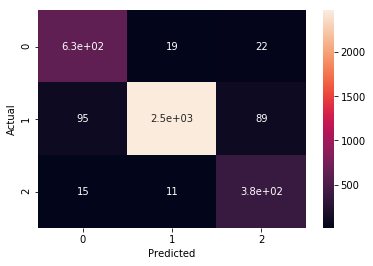

In [34]:
import pandas as pd
import seaborn as sns

data_y = {'y_Predicted': output_df,'y_Actual': y_Actual_temp}
df = pd.DataFrame(data_y, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

Getting additional stats using pandas_ml

In [36]:
!pip install pandas_ml

    100% |████████████████████████████████| 102kB 26.1MB/s a 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
from pandas_ml import ConfusionMatrix

Confusion_Matrix = ConfusionMatrix(df['y_Actual'], df['y_Predicted'])
Confusion_Matrix.print_stats()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas_ml/confusion_matrix/stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Confusion Matrix:

Predicted    0     1    2  __all__
Actual                            
0          626    19   22      667
1           95  2473   89     2657
2           15    11  378      404
__all__    736  2503  489     3728


Overall Statistics:

Accuracy: 0.9326716738197425
95% CI: (0.9241489309480853, 0.9405081331157233)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0
Kappa: 0.8573377679220069
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1           2
Population                                  3728       3728        3728
P: Condition positive                        667       2657         404
N: Condition negative                       3061       1071        3324
Test outcome positive                        736       2503         489
Test outcome negative                       2992       1225        3239
TP: True Positive                            626       2473         378
TN: True Negative                      

## Results<a id='res'></a>

<font color="green">we can see in the stats report that the "Accuracy" value increased from 92.84% to 93.27%</font>